# Neural network classifier for mushrooms

In [ ]:
import os
import shutil
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.python.framework.config import list_physical_devices, set_memory_growth
from keras.utils import image_dataset_from_directory

In [ ]:
# To fix "Image File is truncated" error during training
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the Dataset
!unzip /content/drive/Shareddrives/Progetto_CIDL/Dataset_4c_avg.zip	

Archive:  /content/drive/Shareddrives/Progetto_CIDL/Dataset_4c_avg.zip
   creating: Dataset_4c_avg/test/
   creating: Dataset_4c_avg/test/Amanita/
  inflating: Dataset_4c_avg/test/Amanita/006_862rFWvLb4I.jpg  
  inflating: Dataset_4c_avg/test/Amanita/008_euaqSUZFtMY.jpg  
  inflating: Dataset_4c_avg/test/Amanita/016_S-Z6ZIo2G3k.jpg  
  inflating: Dataset_4c_avg/test/Amanita/018_fu20lV1Ks10.jpg  
  inflating: Dataset_4c_avg/test/Amanita/019_dC7dMPodoSA.jpg  
  inflating: Dataset_4c_avg/test/Amanita/021_2-PKYWYCnqU.jpg  
  inflating: Dataset_4c_avg/test/Amanita/029_EZRk61kOaKI.jpg  
  inflating: Dataset_4c_avg/test/Amanita/033_p_kC9KT-lGU.jpg  
  inflating: Dataset_4c_avg/test/Amanita/037_xyM5ztH9BRk.jpg  
  inflating: Dataset_4c_avg/test/Amanita/050_ag9Ii9vTCdA.jpg  
  inflating: Dataset_4c_avg/test/Amanita/058_qwNykVN8aEo.jpg  
  inflating: Dataset_4c_avg/test/Amanita/069_szzmCkEtJbo.jpg  
  inflating: Dataset_4c_avg/test/Amanita/071_SDRvTCrFXG8.jpg  
  inflating: Dataset_4c_avg/test/A

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
# Settings for displaying charts
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 12})

In [ ]:
physical_devices = list_physical_devices('GPU')
print(f'Number of GPUs available: {len(physical_devices)}')

if len(physical_devices) > 0:
    set_memory_growth(physical_devices[0], True)

Number of GPUs available: 1


In [ ]:
# TensorFlow settings
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SIZE = 299
BATCH_SIZE = 32

## Loading and processing data

In [ ]:
data_path = './Dataset_4c_avg'

Class used: 4


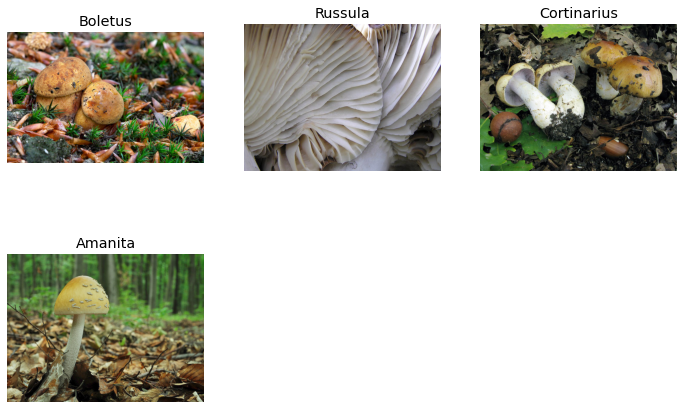

In [ ]:
# Displaying examples from each class
nrows = 3
ncols = 3

pos = 0

test_path = './Dataset_4c_avg/test/'
train_path = './Dataset_4c_avg/train/'

k = 0
for subfolder in os.listdir(test_path):
    
    k = k + 1
    image_file = os.listdir(os.path.join(test_path, subfolder))[0]
    
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    pos += 1
    sp = plt.subplot(nrows, ncols, pos)

    cur_image = mpimg.imread(os.path.join(test_path, subfolder, image_file))
    plt.imshow(cur_image)
    plt.title(subfolder)
    plt.axis('Off')

class_number = k
print(f"Class used: {class_number}")

In [ ]:
# Create image datasets
train_data = image_dataset_from_directory(train_path, labels='inferred', 
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, 
    subset='training', validation_split=0.2, seed=1234)


validation_data = image_dataset_from_directory(train_path, labels='inferred', 
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, 
    subset='validation', validation_split=0.2, seed=1234)

test_data = image_dataset_from_directory(test_path, labels='inferred', 
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)


test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory=test_path,
                                         target_size=(IMG_SIZE, IMG_SIZE),
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)

Found 3424 files belonging to 4 classes.
Using 2740 files for training.
Found 3424 files belonging to 4 classes.
Using 684 files for validation.
Found 382 files belonging to 4 classes.
Found 382 images belonging to 4 classes.


Add data augmentation function

In [ ]:
from keras import layers

def get_data_augmentation():
  # augment the dataset to reduce overfitting
  data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.3),
    layers.RandomBrightness(0.6),
    layers.RandomTranslation(0.2, 0.2)
  ])

  return data_augmentation

data_augmentation = get_data_augmentation()

**FEATURES EXTRACTION**


In [ ]:
# Pretrained EfficientNetB7 image classification model without final layers
feature_model = tf.keras.applications.vgg16.VGG16(weights='imagenet',
                                                     include_top=False,
                                                     input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                     pooling='max')

feature_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0     

In [ ]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = feature_model(x)

x = layers.Dropout(0.5)(x)

outputs = layers.Dense(class_number, activation="softmax")(x)
new_model = tf.keras.Model(inputs, outputs)

In [ ]:
# Make all the layers from the original ResNet model untrainable
new_model.layers[4].trainable = False

In [ ]:
# Metrics and optimizer
new_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
# Check the architecture of the new model
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 299, 299, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0   

In [ ]:
# Callbacks to be exercised during training
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.1,
                                                 mode='max',
                                                 cooldown=2,
                                                 patience=2,
                                                 min_lr=1e-6)

In [ ]:
dir_name = "/content/drive/Shareddrives/Progetto_CIDL/Models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name, 'CNN_pretrained_VGG16.h5')

callbacks_list = [
    earlystopping,
    reduce_lr,
    tf.keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True)
]

# Train new model:
history = new_model.fit(train_data,
                        validation_data=validation_data,
                        epochs=30,
                        verbose=1,
                        callbacks=callbacks_list,
                        use_multiprocessing=True,
                        workers=2)

Epoch 1/30


86/86 [==============================] - ETA: 0s - loss: 41.4955 - accuracy: 0.3288
Epoch 1: val_loss improved from inf to 15.89620, saving model to /content/drive/Shareddrives/Progetto_CIDL/Models/CNN_pretrained_VGG16.h5
86/86 [==============================] - 38s 365ms/step - loss: 41.4955 - accuracy: 0.3288 - val_loss: 15.8962 - val_accuracy: 0.5789 - lr: 0.0010
Epoch 2/30
86/86 [==============================] - ETA: 0s - loss: 27.9053 - accuracy: 0.4120
Epoch 2: val_loss improved from 15.89620 to 10.60462, saving model to /content/drive/Shareddrives/Progetto_CIDL/Models/CNN_pretrained_VGG16.h5
86/86 [==============================] - 32s 364ms/step - loss: 27.9053 - accuracy: 0.4120 - val_loss: 10.6046 - val_accuracy: 0.6798 - lr: 0.0010
Epoch 3/30
86/86 [==============================] - ETA: 0s - loss: 21.4848 - accuracy: 0.4763
Epoch 3: val_loss improved from 10.60462 to 8.25358, saving model to /content/drive/Shareddrives/Progetto_CIDL/Models/CNN_pretrained_VGG16.h5
86/86 [==

# Displaying the results

In [ ]:
loss, accuracy = new_model.evaluate(test_data,
                                    steps=11, 
                                    verbose=2, 
                                    use_multiprocessing=True, 
                                    workers=2)
print(f'Model performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')

11/11 - 1s - loss: 7.0982 - accuracy: 0.7614 - 598ms/epoch - 54ms/step
Model performance on test images:
Accuracy = 0.7613636255264282
Loss = 7.098184108734131


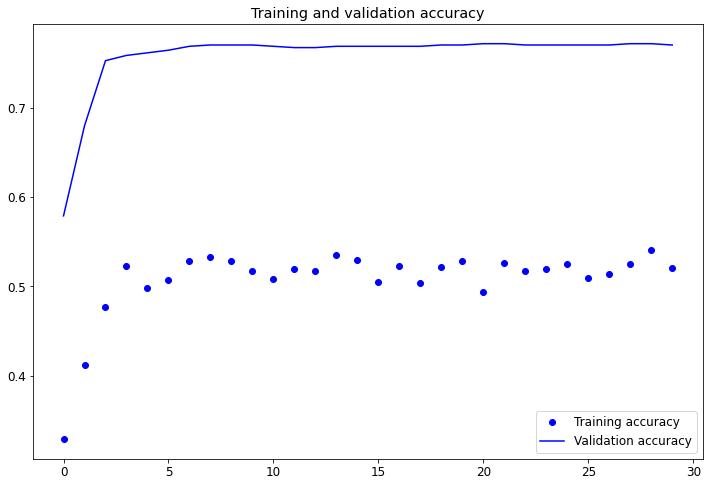

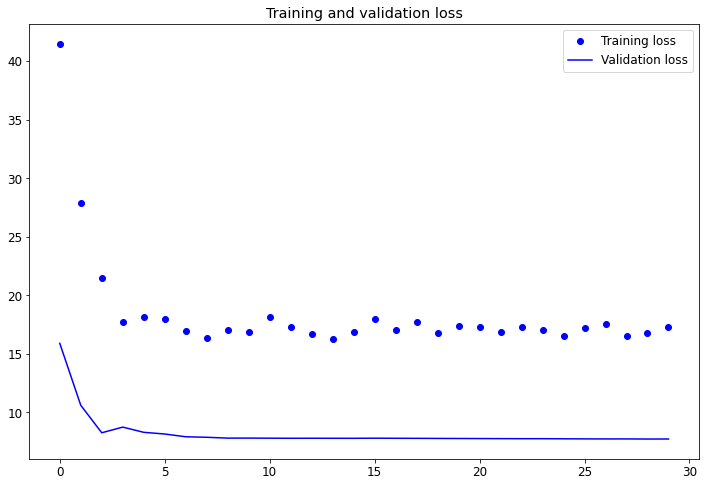

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

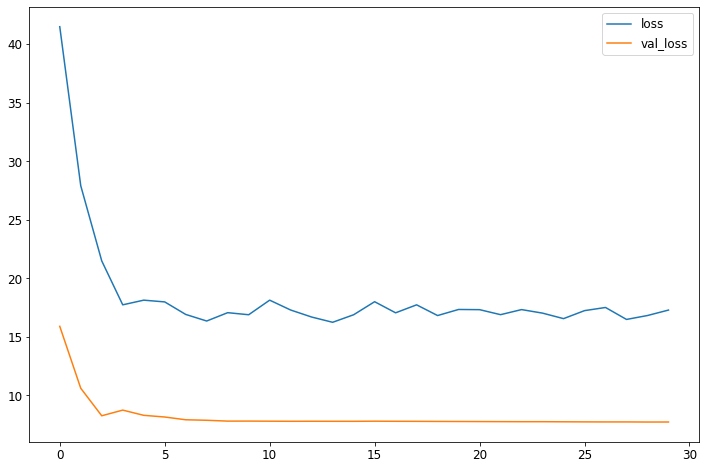

In [ ]:
# Loss during training:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot();

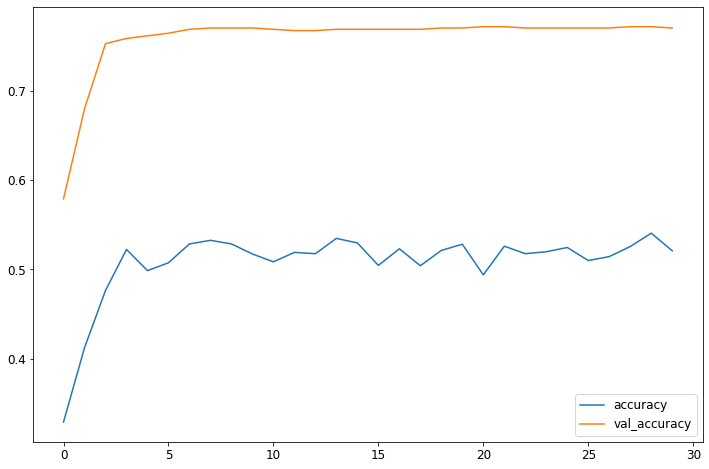

In [ ]:
# Accuracy during training:
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [ ]:
type(train_data.class_names)

list

<ipython-input-47-41f75255bb19>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = new_model.predict_generator(test_generator, nb_samples // BATCH_SIZE+1)


Confusion Matrix
[[36 21  3 15]
 [ 2 97  7  2]
 [ 5  8 45 26]
 [13 16  9 77]]
Classification Report
              precision    recall  f1-score   support

     Amanita       0.64      0.48      0.55        75
     Boletus       0.68      0.90      0.78       108
 Cortinarius       0.70      0.54      0.61        84
     Russula       0.64      0.67      0.66       115

    accuracy                           0.67       382
   macro avg       0.67      0.65      0.65       382
weighted avg       0.67      0.67      0.66       382



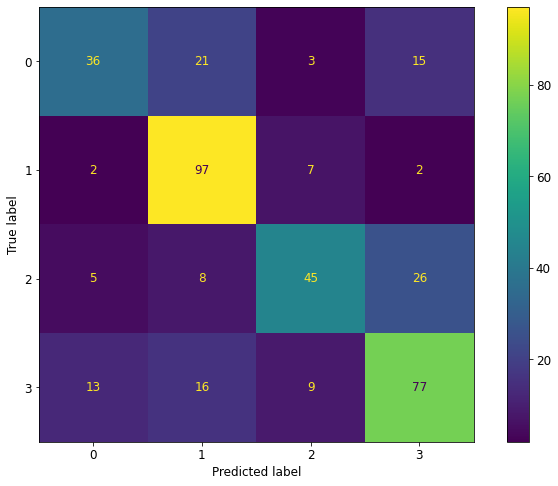

In [ ]:
from pandas.core.dtypes.common import classes
import numpy as np
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

nb_samples = 382 # number of test images
Y_pred = new_model.predict_generator(test_generator, nb_samples // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)
# x is true class, y is predicted class-- middle diagonal represents the accurate predictions

print('Classification Report')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

disp = metrics.ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

**FINE TUNING**

In [ ]:
feature_model.trainable = True

set_trainable = False
for layer in feature_model.layers:
    if layer.name == 'block5_conv3':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
# Metrics and optimizer
new_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 299, 299, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0   

In [ ]:
# Callbacks to be exercised during training
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              mode='min',
                                              patience=5,
                                              restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.1,
                                                 mode='max',
                                                 cooldown=2,
                                                 patience=2,
                                                 min_lr=0)

In [ ]:
# Train new model:
history = new_model.fit(train_data,
                        validation_data=validation_data,
                        epochs=30,
                        verbose=1,
                        callbacks=[reduce_lr, early_stop],
                        use_multiprocessing=True,
                        workers=2)

Epoch 1/30


86/86 [==============================] - 38s 359ms/step - loss: 16.9422 - accuracy: 0.5788 - val_loss: 3.6121 - val_accuracy: 0.8260 - lr: 0.0010
Epoch 2/30
86/86 [==============================] - 31s 356ms/step - loss: 4.0274 - accuracy: 0.6796 - val_loss: 3.0853 - val_accuracy: 0.7953 - lr: 0.0010
Epoch 3/30
86/86 [==============================] - 31s 355ms/step - loss: 1.7984 - accuracy: 0.7018 - val_loss: 0.8884 - val_accuracy: 0.8436 - lr: 0.0010
Epoch 4/30
86/86 [==============================] - 31s 358ms/step - loss: 1.0852 - accuracy: 0.7000 - val_loss: 0.6731 - val_accuracy: 0.8684 - lr: 1.0000e-04
Epoch 5/30
86/86 [==============================] - 31s 355ms/step - loss: 0.9505 - accuracy: 0.7131 - val_loss: 0.6743 - val_accuracy: 0.8655 - lr: 1.0000e-04
Epoch 6/30
86/86 [==============================] - 31s 356ms/step - loss: 0.8703 - accuracy: 0.7124 - val_loss: 0.6169 - val_accuracy: 0.8611 - lr: 1.0000e-04
Epoch 7/30
86/86 [==============================] - 31s 355ms/

In [ ]:
loss, accuracy = new_model.evaluate(test_data,
                                    steps=11, 
                                    verbose=2, 
                                    use_multiprocessing=True, 
                                    workers=2)
print(f'Model performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')

11/11 - 1s - loss: 0.5214 - accuracy: 0.8580 - 600ms/epoch - 55ms/step
Model performance on test images:
Accuracy = 0.8579545617103577
Loss = 0.5214197635650635


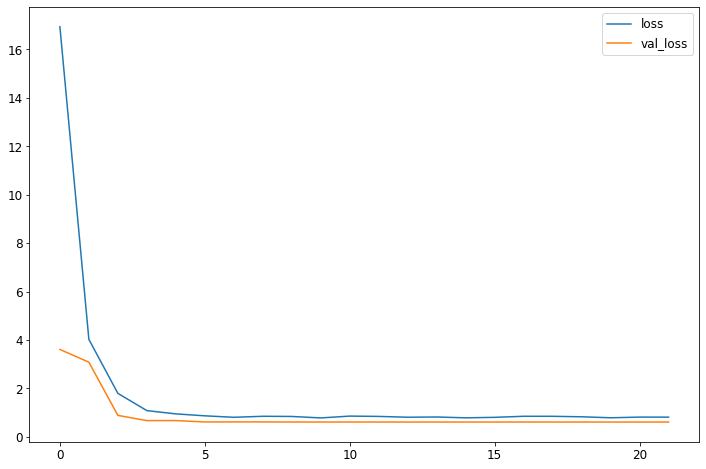

In [ ]:
# Loss during training:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot();

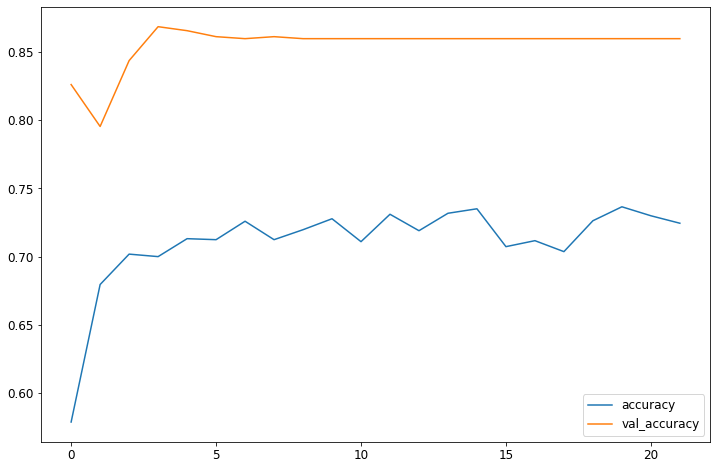

In [ ]:
# Accuracy during training:
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

<ipython-input-56-41f75255bb19>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = new_model.predict_generator(test_generator, nb_samples // BATCH_SIZE+1)


Confusion Matrix
[[63  5  4  3]
 [ 4 98  2  4]
 [14  4 51 15]
 [19  4  5 87]]
Classification Report
              precision    recall  f1-score   support

     Amanita       0.63      0.84      0.72        75
     Boletus       0.88      0.91      0.89       108
 Cortinarius       0.82      0.61      0.70        84
     Russula       0.80      0.76      0.78       115

    accuracy                           0.78       382
   macro avg       0.78      0.78      0.77       382
weighted avg       0.79      0.78      0.78       382



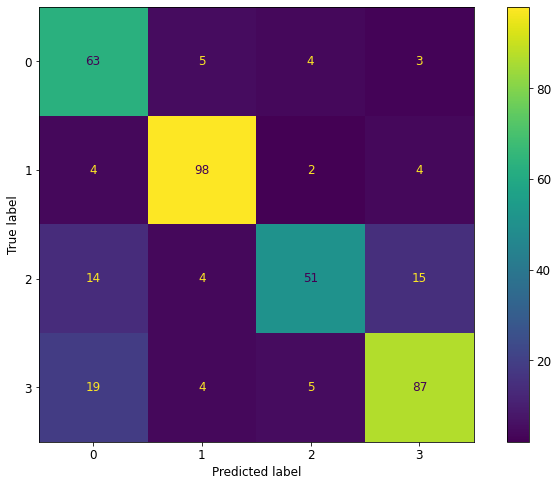

In [ ]:
from pandas.core.dtypes.common import classes
import numpy as np
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

nb_samples = 382 # number of test images
Y_pred = new_model.predict_generator(test_generator, nb_samples // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)
# x is true class, y is predicted class-- middle diagonal represents the accurate predictions

print('Classification Report')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

disp = metrics.ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()